In [11]:
import os
import random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score, classification_report
import warnings
warnings.filterwarnings("ignore")

random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)

In [12]:
%%capture
!pip install wandb --upgrade

In [13]:
import wandb
wandb.login()

wandb: Currently logged in as: georgequine (use `wandb login --relogin` to force relogin)


True

In [14]:
#Weights & Biases parameters used for experimentation 
#Commented out parameter range once finalised

import math
import pprint

sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'accuracy',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

parameters_dict = {

    'criterion': {
        # 'values': ['gini', 'entropy']
        'values': ['entropy']
        },
    'random_state':{
        'values': [42]
        },
    'min_samples_leaf':{
        'values': [1]
        },
    'min_samples_split':{
        'values': [2]
        },
    'n_estimators':{
        'values': [120]
        },
    'max_depth':{
        'values': [20]
        }
    }

    
# parameters_dict.update({
#     'n_estimators': {
#         # a flat distribution between 0 and 0.1
#         'distribution': 'int_uniform',
#         'min': 5,
#         'max': 500
#       }
#     })

# parameters_dict.update({
#     'max_depth': {
#         # a flat distribution between 0 and 0.1
#         'distribution': 'int_uniform',
#         'min': 1,
#         'max': 100
#       }
#     })

# parameters_dict.update({
#     'min_samples_split': {
#         # a flat distribution between 0 and 0.1
#         'distribution': 'int_uniform',
#         'min': 2,
#         'max': 50
#       }
#     })

# parameters_dict.update({
#     'min_samples_leaf': {
#         # a flat distribution between 0 and 0.1
#         'distribution': 'int_uniform',
#         'min': 1,
#         'max': 10
#       }
#     })    

sweep_config['parameters'] = parameters_dict

pprint.pprint(sweep_config)
sweep_id = wandb.sweep(sweep_config, project="rf_Test9")

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'accuracy'},
 'parameters': {'criterion': {'values': ['entropy']},
                'max_depth': {'values': [20]},
                'min_samples_leaf': {'values': [1]},
                'min_samples_split': {'values': [2]},
                'n_estimators': {'values': [120]},
                'random_state': {'values': [42]}}}
Create sweep with ID: lazaxwsg
Sweep URL: https://wandb.ai/georgequine/rf_Test9/sweeps/lazaxwsg


In [15]:
#Connect to google drive

from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#Read Training Data 

df = pd.read_csv('/content/drive/MyDrive/Masters Final Code/Training Data /full_dataset.csv')
df

,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,...,12962,12963,12964,12965,12966,12967,12968,12969,12970,12971,12972,12973,12974,12975,12976,12977,12978,12979,12980,12981,12982,12983,12984,12985,12986,12987,12988,12989,12990,12991,12992,12993,12994,12995,12996,12997,12998,12999,13000,label
0,59.266940,58.975565,56.977616,55.014508,53.877194,53.220730,50.860882,47.463943,44.173050,40.728620,37.778277,34.656815,30.961166,28.576316,25.705487,23.429298,20.835799,18.086858,15.982501,14.069913,12.669504,11.605206,11.241240,11.183826,10.949130,11.554249,12.700787,13.914162,15.318965,16.672831,17.866379,19.045740,20.124406,21.208071,22.141830,22.676671,23.277050,23.543391,23.519463,23.260488,...,34.735554,34.765562,34.678664,34.512007,34.322563,34.103119,33.842738,33.493695,33.197472,32.807479,32.425769,32.041632,31.645223,31.282365,30.997365,30.771227,30.586665,30.418362,30.329322,30.428226,30.579591,30.771811,31.007821,31.259095,31.511969,31.808180,32.068951,32.377991,32.599538,32.812502,32.972029,33.047066,33.044833,32.958811,32.751570,32.525590,32.321445,32.090483,31.853165,anticlockwise
1,9.430219,6.761833,9.067841,12.187881,14.981282,16.715642,19.715080,23.163117,25.447648,27.718549,30.377929,32.616499,34.647300,36.321364,37.409992,38.749442,39.357017,40.390042,40.389234,39.849927,39.231486,38.059002,36.888366,35.158190,33.319958,31.756469,30.249104,28.391213,26.696637,25.092950,23.396958,21.607635,20.131839,19.009112,18.332633,17.719721,17.272350,17.154719,17.396746,17.995878,...,30.017048,30.265275,30.600462,30.848805,31.067650,31.200203,31.212855,31.137469,30.994356,30.755191,30.530855,30.300401,29.958972,29.662847,29.243039,28.907576,28.483592,28.041963,27.617938,27.291661,27.000971,26.829175,26.650888,26.527821,26.522587,26.673186,26.940109,27.132103,27.410858,27.685320,27.858208,28.118958,28.397762,28.634164,28.792600,28.979371,29.104917,29.082998,28.982344,anticlockwise
2,2.868740,2.638707,-0.119674,-0.770817,-0.523272,0.400442,1.812526,2.644360,4.213869,5.531512,7.156005,8.800867,10.671912,13.126050,15.357117,17.718541,19.743324,21.475337,23.093008,25.120537,26.951150,27.875134,28.923155,29.700597,30.265234,30.548805,30.301771,29.617393,28.597515,27.448084,26.425182,25.307582,23.913099,22.815762,21.488140,20.367087,19.073577,17.700016,16.588129,15.796413,...,34.881854,35.148785,35.417311,35.545756,35.606420,35.621083,35.593693,35.447691,35.215229,34.900662,34.608659,34.327760,33.992264,33.643252,33.272813,32.825891,32.368992,32.017913,31.710410,31.475204,31.266631,31.121929,31.078878,31.165161,31.332728,31.504093,31.739346,31.957377,32.201025,32.468668,32.688856,32.929781,33.111370,33.276577,33.409469,33.469222,33.438192,33.278108,33.053418,anticlockwise
3,-23.941770,-24.585864,-23.475114,-20.766808,-17.370528,-14.256579,-11.572156,-8.461068,-3.922998,0.160036,4.051118,7.858369,10.914839,13.832789,16.368720,18.394049,20.390406,22.037248,23.101412,23.897198,24.110355,24.116469,23.503537,22.396112,21.447701,20.610410,19.732168,18.652795,17.841939,17.383684,17.067991,16.850357,16.726509,16.915540,17.232486,17.454309,18.071009,19.100583,20.086145,20.754245,...,30.892966,30.692160,30.469059,30.269131,30.062083,29.953660,29.854667,29.751801,29.729367,29.770015,29.794164,29.878503,30.013778,30.244121,30.562816,30.903089,31.163605,31.496989,31.860004,32.171123,32.417351,32.717307,32.927582,33.158691,33.281369,33.328732,33.239581,33.146154,32.939934,32.754137,32.531472,32.194415,31.838391,31.475434,31.081774,30.626135,30.198868,29.761125,29.450418,anticlockwise
4,17.395550,18.192997,16.825123,13.345473,9.850659,8.191031,5.703118,5.081544,3.776101,3.805677,4.666533,5.248170,6.371694,7.113687,8.597010,10.451168,12.147938,13.876962,16.093001,18.214960,20.409131,22.031014,23.802472,25.350971,26.595183,27.832736,28.788830,29.533239,29.645163,29.620110,29.254347,28.737529,27.991383,26

In [16]:
lb = LabelEncoder()
df['label'] = lb.fit_transform(df['label'])

In [17]:
df2 = df.transpose()
df2 = df2.head(df2.shape[0] -1)
df2.columns = df2.columns.map(str)
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048
1001,59.266940,9.430219,2.868740,-23.941770,17.395550,-7.461775,-2.029481,1.754814,5.493331,28.382210,34.730060,-17.883850,5.279702,34.989470,50.798050,52.186650,-8.316293,1.358074,-8.957183,52.690200,15.625480,31.434060,-1.968444,31.052580,8.560441,-7.889034,3.021332,51.774650,48.417610,-7.736442,43.534650,-7.553330,58.412420,13.916440,6.561479,50.584420,31.739250,16.647850,-6.469923,51.515240,...,-17.181920,3.326517,75.029750,-24.094360,78.539380,11.032440,-5.752738,76.204710,69.170200,57.847830,69.460120,83.925900,59.007530,85.833310,-11.352890,19.074070,-10.208440,65.157010,60.533460,-23.133030,13.626510,-16.968290,2.548295,8.270515,-8.163701,17.502370,73.931080,69.536420,-18.173770,68.971820,78.646190,54.399240,-25.147250,36.225470,-18.662070,91.036710,1.037629,84.933010,8.606219,46.845910
1002,58.975565,6.761833,2.638707,-24.585864,18.192997,-6.648991,-2.313188,-1.342967,3.929105,22.608374,38.540945,-22.009109,2.020898,36.492352,50.767382,45.868401,-8.791695,-3.342272,-9.187215,53.924717,10.810115,29.049381,-2.689215,24.672991,3.714407,-2.720954,-1.172941,48.055778,46.608017,-3.534501,41.648381,-11.985305,62.859731,17.765665,-0.178495,45.308994,32.766732,13.703421,-7.965139,54.758712,...,-13.409375,7.597467,80.519879,-18.642572,79.091462,13.095072,-5.775741,70.883275,72.582356,56.183927,66.047964,76.158441,61.990295,85.848641,-5.172661,11.544314,-15.330513,64.420908,64.252332,-22.343251,7.392611,-14.729301,1.881199,7.227698,-3.693388,14.450592,70.012851,70.011825,-23.978278,66.633150,74.720293,57.036958,-29.809259,27.415193,-12.627530,88.145958,2.187795,85.929819,5.201727,38.334681
1003,56.977616,9.067841,-0.119674,-23.475114,16.825123,-2.447986,-1.164512,-3.480060,2.596010,18.757314,39.816335,-24.072556,1.576836,37.414560,49.991692,45.493681,-11.215737,-0.331609,-11.955871,53.699174,8.121063,23.707948,-1.434490,22.150956,-2.134073,-3.428292,-4.189254,47.062791,43.919068,-4.286457,38.019421,-12.851234,63.746182,21.072818,0.564869,40.118817,35.554599,12.172280,-7.564489,52.562191,...,-16.770395,12.334671,81.887496,-12.047619,79.326856,17.224628,-0.050108,70.902467,70.986625,50.805320,59.393081,68.622091,64.895619,83.896417,-3.559604,9.347858,-13.184790,66.559285,67.413289,-22.639970,6.059632,-9.282305,4.468980,13.543268,-1.612536,10.643777,70.494622,69.528116,-29.221514,66.613953,74.464862,60.608145,-27.777328,21.899575,-8.093637,84.901419,4.682629,81.633310,2.772318,33.268080
1004,55.014508,12.187881,-0.770817,-20.766808,13.345473,1.638862,0.184243,-1.284267,0.225717,12.688600,40.349448,-22.715065,-1.948192,42.049902,49.100478,42.665473,-13.349286,0.089425,-13.402086,53.687087,6.211259,19.050913,-0.838137,19.654762,-4.368909,-2.678359,-5.279136,47.445317,42.206799,-3.523982,33.997865,-12.943420,65.176805,24.778593,-0.097352,36.071774,39.933950,9.664246,-8.239297,51.626619,...,-16.747040,21.038116,80.077557,-7.526685,79.119282,23.769467,4.446645,69.812348,68.674759,43.763770,53.362995,63.150325,70.142988,79.911632,-2.865410,6.743389,-9.207813,66.896570,68.881394,-20.360437,4.173424,-4.057485,9.584694,19.322391,-1.032957,4.655266,67.320190,70.908735,-31.622283,61.876367,72.660481,66.250384,-25.510685,17.608504,-5.795825,85.463163,7.947412,76.546145,-0.246783,28.307022
1005,53.877194,14.981282,-0.523272,-17.370528,9.850659,3.763922,2.198247,0.148309,-1.806550,10.205722,40.292598,-21.558175,-5.657022,44.687713,50.246907,38.885936,-15.843475,2.757865,-15.237960,52.157483,4.265363,15.596881,-0.819687,16.382625,-6.615662,-1.257114,-6.452925,45.856713,41.518844,-1.905307,28.462560,-10.651382,66.682665,27.839358,1.012127,32.812488,42.296764,8.906692,-11.377536,50.579657,...,-15.895581,28.793972,77.923842,-5.592603,78.182

In [18]:
#WORKING NORMALISATION MIN MAX

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler


Complete_x = []


for i in range(0,1049):
  x2 = df2.iloc[:-1 , :]

  x2 = df2.iloc[:, i].values
  y1 = df.loc[:,['label']].values

  x_data = x2
  x_data = np.array(x_data)
  x_data = x_data.reshape(-1,1)
  # print(x_data)

  #array to hold normalised data
  data_array = []
  norm = []

  #MinMax done here, normalised data added to data array
  scaler2 = MinMaxScaler()
  norm = scaler2.fit_transform(x_data)
  data_array = norm
  data_array = data_array.flatten()

  # Initialise the dataframe with first gestrue
  if (i == 0):
    Complete_x = data_array
    normDF = pd.DataFrame(data = Complete_x, columns = [f'gesture{i}'])

  #further gestures are appended to the dataframe
  if (i > 0):
    Complete_x = data_array
    normDF[f'gesture{i}'] = Complete_x

normDF

,gesture0,gesture1,gesture2,gesture3,gesture4,gesture5,gesture6,gesture7,gesture8,gesture9,gesture10,gesture11,gesture12,gesture13,gesture14,gesture15,gesture16,gesture17,gesture18,gesture19,gesture20,gesture21,gesture22,gesture23,gesture24,gesture25,gesture26,gesture27,gesture28,gesture29,gesture30,gesture31,gesture32,gesture33,gesture34,gesture35,gesture36,gesture37,gesture38,gesture39,...,gesture1009,gesture1010,gesture1011,gesture1012,gesture1013,gesture1014,gesture1015,gesture1016,gesture1017,gesture1018,gesture1019,gesture1020,gesture1021,gesture1022,gesture1023,gesture1024,gesture1025,gesture1026,gesture1027,gesture1028,gesture1029,gesture1030,gesture1031,gesture1032,gesture1033,gesture1034,gesture1035,gesture1036,gesture1037,gesture1038,gesture1039,gesture1040,gesture1041,gesture1042,gesture1043,gesture1044,gesture1045,gesture1046,gesture1047,gesture1048
0,1.000000,0.830369,0.804591,0.723090,0.879138,0.819156,0.831295,0.839378,0.855903,0.948849,0.964412,0.781100,0.862683,0.949334,1.000000,1.000000,0.811939,0.857039,0.807940,0.995741,0.869962,0.937263,0.833598,0.946005,0.863990,0.806821,0.834689,1.000000,1.000000,0.800738,0.896450,0.716214,0.934907,0.820138,0.789518,0.948197,0.885029,0.823055,0.773499,0.978735,...,0.546268,0.588650,0.823434,0.513638,0.847647,0.656000,0.591364,0.865003,0.845438,0.796379,0.770040,0.842057,0.790666,0.862944,0.620981,0.719036,0.648596,0.830487,0.857581,0.594352,0.698627,0.601540,0.676663,0.682966,0.604520,0.701187,0.848882,0.826273,0.593596,0.808170,0.839571,0.768110,0.618104,0.738868,0.589837,0.821054,0.633328,0.801464,0.613196,0.733915
1,0.998999,0.820952,0.803786,0.720819,0.881928,0.822018,0.830338,0.828733,0.850357,0.927077,0.978567,0.765980,0.851128,0.954687,0.999889,0.978358,0.810168,0.840533,0.807128,1.000000,0.853205,0.929291,0.831078,0.922630,0.845989,0.825994,0.818970,0.986723,0.993287,0.816187,0.890131,0.701118,0.949176,0.833463,0.765935,0.929716,0.888523,0.812524,0.768338,0.990083,...,0.557473,0.602229,0.839823,0.530594,0.849403,0.662700,0.591289,0.848139,0.856647,0.791201,0.762825,0.825149,0.797444,0.862979,0.635208,0.700970,0.636241,0.828675,0.866826,0.596198,0.683443,0.606926,0.675164,0.680541,0.615105,0.693909,0.839392,0.827419,0.579556,0.802427,0.830030,0.774715,0.606540,0.717276,0.604146,0.814588,0.636110,0.803761,0.605100,0.712775
2,0.992136,0.829090,0.794141,0.724736,0.877142,0.836814,0.834214,0.821390,0.845630,0.912555,0.983305,0.758417,0.849553,0.957972,0.997076,0.977075,0.801134,0.851105,0.797353,0.999222,0.843847,0.911436,0.835466,0.913389,0.824263,0.823370,0.807665,0.983178,0.983311,0.813423,0.877974,0.698168,0.952020,0.844911,0.768536,0.911533,0.898003,0.807047,0.769721,0.982398,...,0.547490,0.617291,0.843905,0.551105,0.850151,0.676114,0.609713,0.848200,0.851405,0.774463,0.748751,0.808744,0.804046,0.858424,0.638921,0.695701,0.641417,0.833938,0.874683,0.595505,0.680197,0.620028,0.680980,0.695226,0.620033,0.684832,0.840559,0.826253,0.566873,0.802380,0.829409,0.783657,0.611580,0.703758,0.614897,0.807331,0.642145,0.793862,0.599323,0.700191
3,0.985392,0.840101,0.791864,0.734288,0.864970,0.851207,0.838765,0.828935,0.837225,0.889671,0.985285,0.763392,0.837054,0.974482,0.993844,0.967388,0.793183,0.852584,0.792246,0.999180,0.837201,0.895868,0.837552,0.904243,0.815961,0.826152,0.803580,0.984544,0.976959,0.816226,0.864502,0.697854,0.956610,0.857739,0.766219,0.897355,0.912895,0.798077,0.767391,0.979125,...,0.547560,0.644963,0.838502,0.565167,0.849491,0.697375,0.624182,0.844745,0.843810,0.752550,0.735999,0.796833,0.815970,0.849125,0.640519,0.689452,0.651009,0.834768,0.878332,0.600835,0.675602,0.632595,0.692479,0.708664,0.621405,0.670551,0.832870,0.829583,0.561066,0.790745,0.825025,0.797785,0.617202,0.693241,0.620346,0.808588,0.650043,0.782141,0.592143,0.687869
4,0.981485,0.849959,0.792729,0.746266,0.852743,0.858692,0.845560,0.833858,0.830019,0.880309,0.985074,0.767633,0.823904,0.983878,0.998001,0.954442,0.783887,0.861955,0.785764,0.993904,0.830430,0.884322,0.837616,0.892254,0.8

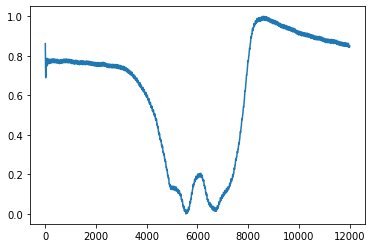

In [19]:
#Plot Graph of gesture 

from matplotlib import pyplot as plt

#To create a time array between range <-- used for plotting 
time_array = []
for n in range(0,12000):
  time_array.append(n)

#Choose the gesture index to plot
gesture_index = 100

graph = normDF.iloc[:, gesture_index].values
plt.plot(time_array,graph)

In [20]:
transposed_normDF = normDF.transpose()
df_label = df.loc[:,['label']].values
label = df_label
transposed_normDF['label'] = label
transposed_normDF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,11961,11962,11963,11964,11965,11966,11967,11968,11969,11970,11971,11972,11973,11974,11975,11976,11977,11978,11979,11980,11981,11982,11983,11984,11985,11986,11987,11988,11989,11990,11991,11992,11993,11994,11995,11996,11997,11998,11999,label
gesture0,1.000000,0.998999,0.992136,0.985392,0.981485,0.979230,0.971123,0.959453,0.948148,0.936316,0.926181,0.915457,0.902762,0.894569,0.884707,0.876888,0.867978,0.858535,0.851306,0.844736,0.839925,0.836269,0.835018,0.834821,0.834015,0.836094,0.840032,0.844201,0.849027,0.853677,0.857778,0.861829,0.865535,0.869257,0.872465,0.874302,0.876365,0.877280,0.877198,0.876308,...,0.915728,0.915831,0.915532,0.914960,0.914309,0.913555,0.912661,0.911462,0.910444,0.909104,0.907793,0.906474,0.905112,0.903865,0.902886,0.902109,0.901475,0.900897,0.900591,0.900931,0.901451,0.902111,0.902922,0.903785,0.904654,0.905672,0.906567,0.907629,0.908390,0.909122,0.909670,0.909927,0.909920,0.909624,0.908912,0.908136,0.907435,0.906641,0.905826,0
gesture1,0.830369,0.820952,0.829090,0.840101,0.849959,0.856079,0.866664,0.878832,0.886894,0.894908,0.904293,0.912193,0.919360,0.925268,0.929110,0.933836,0.935981,0.939626,0.939623,0.937720,0.935538,0.931400,0.927269,0.921163,0.914676,0.909158,0.903839,0.897282,0.891302,0.885643,0.879658,0.873343,0.868135,0.864173,0.861786,0.859623,0.858044,0.857629,0.858483,0.860597,...,0.903020,0.903896,0.905079,0.905955,0.906727,0.907195,0.907240,0.906974,0.906469,0.905625,0.904833,0.904020,0.902815,0.901770,0.900288,0.899105,0.897608,0.896050,0.894553,0.893402,0.892376,0.891770,0.891141,0.890706,0.890688,0.891219,0.892161,0.892839,0.893823,0.894791,0.895401,0.896321,0.897305,0.898140,0.898699,0.899358,0.899801,0.899724,0.899368,0
gesture2,0.804591,0.803786,0.794141,0.791864,0.792729,0.795959,0.800897,0.803806,0.809295,0.813902,0.819583,0.825335,0.831878,0.840460,0.848262,0.856520,0.863600,0.869657,0.875314,0.882404,0.888806,0.892037,0.895702,0.898420,0.900395,0.901387,0.900523,0.898129,0.894563,0.890544,0.886966,0.883058,0.878182,0.874345,0.869702,0.865782,0.861258,0.856455,0.852567,0.849798,...,0.916539,0.917472,0.918411,0.918861,0.919073,0.919124,0.919028,0.918518,0.917705,0.916605,0.915584,0.914601,0.913428,0.912208,0.910912,0.909349,0.907752,0.906524,0.905449,0.904626,0.903897,0.903391,0.903240,0.903542,0.904128,0.904727,0.905550,0.906312,0.907164,0.908100,0.908870,0.909713,0.910348,0.910925,0.911390,0.911599,0.911491,0.910931,0.910145,0
gesture3,0.723090,0.720819,0.724736,0.734288,0.746266,0.757249,0.766716,0.777689,0.793694,0.808094,0.821817,0.835245,0.846025,0.856316,0.865260,0.872403,0.879444,0.885252,0.889005,0.891812,0.892564,0.892585,0.890423,0.886518,0.883173,0.880220,0.877122,0.873316,0.870456,0.868840,0.867726,0.866959,0.866522,0.867188,0.868306,0.869089,0.871264,0.874895,0.878371,0.880727,...,0.916485,0.915777,0.914990,0.914285,0.913555,0.913172,0.912823,0.912460,0.912381,0.912524,0.912610,0.912907,0.913384,0.914197,0.915321,0.916521,0.917439,0.918615,0.919896,0.920993,0.921861,0.922919,0.923661,0.924476,0.924909,0.925076,0.924761,0.924432,0.923704,0.923049,0.922264,0.921075,0.919819,0.918539,0.917151,0.915544,0.914037,0.912493,0.911397,0
gesture4,0.879138,0.881928,0.877142,0.864970,0.852743,0.846938,0.838234,0.836060,0.831493,0.831596,0.834608,0.836642,0.840573,0.843169,0.848358,0.854844,0.860780,0.866829,0.874581,0.882005,0.889681,0.895354,0.901552,0.906969,0.911321,0.915651,0.918996,0.921600,0.921991,0.921904,0.920624,0.918816,0.916206,0.912031,0.908362,0.904926,0.900065,0.896156,0.891452,0.886683,...,0.926590,0.927548,0.928306,0.928421,0.928419,0.928118,0.927610,0.926880,0.926099,0.924972,0.923670,0.922516,0.920981,0.919586,0.918382,0.917006,0.915926,0.914785,0.914006,0.913282,0.912463,0.912132,0.912437,0.912949,0.913469,0.914362,0.915280,0.916348,0.917212,0.918129,0.918990,0.920027,0.920738,0.921222,0.921378,0.921430,0.921170,0.920671,0.919908,0
...,...,...,...

In [21]:
#Here PCA is performed

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

transposed_normDF.columns = transposed_normDF.columns.map(str)
features = [str(i) for i in range(0,12000)]
x = transposed_normDF.loc[:, features].values
y = transposed_normDF.loc[:,['label']].values

pca = PCA(n_components=0.99)
principalComponents = pca.fit_transform(x)
pc = pca.explained_variance_ratio_.cumsum()
x1 = StandardScaler().fit_transform(principalComponents)
full_newdf = pd.DataFrame(data = x1
             , columns = [f'pc_stdscaled_{i}' for i in range(len(pc))])
full_finalDf = pd.concat([full_newdf, df[['label']]], axis = 1)
print(full_finalDf)
print(full_newdf.shape)

      pc_stdscaled_0  pc_stdscaled_1  ...  pc_stdscaled_14  label
0           1.366140       -0.522394  ...         1.008495      0
1           1.527681       -0.271857  ...         3.307478      0
2           1.212411        0.157525  ...        -0.103812      0
3           1.446997       -0.239583  ...         0.663721      0
4           1.594918       -0.527705  ...        -0.938883      0
...              ...             ...  ...              ...    ...
1044       -0.834745        0.190272  ...        -0.391056      4
1045       -0.603965       -0.813570  ...        -1.141311      4
1046       -0.192438       -0.879349  ...        -0.613773      4
1047       -0.768363       -0.181243  ...        -1.929741      4
1048       -0.912458       -0.521086  ...         0.050155      4

[1049 rows x 16 columns]
(1049, 15)


In [ ]:
#Training using Weights & Biases

from numpy import loadtxt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load data
def train():
  config_defaults = {
    'n_estimators': 120,
    'criterion': 'entropy',
    'random_state': 42,
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf' : 1

  }

  wandb.init(config=config_defaults)
  config = wandb.config


  X_train, X_test, y_train, y_test = train_test_split(x1, y,
                                                      test_size=0.2,
                                                      random_state=config.random_state)
  
  clf = RandomForestClassifier(n_estimators=config.n_estimators, max_depth=config.max_depth, random_state=config.random_state, criterion=config.criterion, min_samples_split= config.min_samples_split, min_samples_leaf=config.min_samples_leaf)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(np.array(X_test))
  accuracy = accuracy_score(y_test , y_pred)
  print(f"Accuracy: {int(accuracy * 100.)}%")
  wandb.log({"accuracy": accuracy})

wandb.agent(sweep_id, train, count=100)

wandb: Agent Starting Run: fugkjr39 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: wym3f0h1 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: v8qqiq5c with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: 36gki8km with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: trwhput5 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: oyty4puz with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: lc2n7g34 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: r4c6rxek with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: 1sev5jrf with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: 6xkcfay5 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: dtzxamok with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: asuv4kaa with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: 9idlk57e with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: f2giya3v with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: kb1qovi5 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: dj14b1rc with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: rx43k439 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: z59mn3fu with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: qc9ilut6 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: 77epmfne with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k3uxq5jr with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


wandb: Agent Starting Run: c7frftwj with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 20
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 120
wandb: 	random_state: 42


Accuracy: 89%


accuracy,▁
accuracy,0.89048


In [ ]:
#Insert Parameters found from experimentation for final model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(x1, y,
                                                      test_size=0.2,
                                                      random_state=42)
clf = RandomForestClassifier(n_estimators=120, max_depth=20, random_state=42, criterion="entropy", min_samples_split= 2, min_samples_leaf=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(np.array(X_test))
print(y_pred)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {int(acc * 100.)}%")
print(f"Percision: {int(precision * 100.)}%")
print(f"Recall: {int(recall * 100.)}%")
print(f"F-Score: {int(f1 * 100.)}%")

cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
#Evaluation Metrics
from sklearn.metrics import precision_score

acc = accuracy_score(y_pred, y_test)
print("Accuracy: ",round((acc*100),0))
print("Precision: ",round((100 * (precision_score(y_test, y_pred, average="macro"))),0))
print("Recall: ",round((100 * (recall_score(y_test, y_pred, average="macro"))),0))
print("F1: ", round((100 * (f1_score(y_test, y_pred, average="macro"))),0))

In [ ]:
#Save Model 

import pickle
# save the classifier
with open('/content/drive/MyDrive/Masters Final Code/Extra/MODEL_RF.pkl', 'wb') as fid:
    pickle.dump(clf, fid)    

# load it again
with open('/content/drive/MyDrive/Masters Final Code/Extra/MODEL_RF.pkl', 'rb') as fid:
    gnb_loaded = pickle.load(fid)

In [ ]:
#Print model
print(gnb_loaded)

In [ ]:
#Confusion Matrix 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')